# Machine Translation with a Transformer
The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017). This project focuses on creating and training a Transformer model for translating one language to another. Its sequence-to-sequence encoder-decoder architecture is similar to that of the that encoder-decoder RNN model. The main difference is that the recurrent layers are replaced with self-attention layers, which allows the model to easily transmit information across the input sequences.

This notebook mostly follows along with [Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer).

## Essential Packages
Let's start by installing the most recent version of Tensorflow along with installing TensorFlow Datasets for loading the dataset and TensorFlow Text for text preprocessing.

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 3 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 9s (48.6 MB/s)
(Reading database ... 123942 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 to 

Import essential Python packages.

In [2]:
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time
import logging

import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

## Data Preparation
Download the Russian-English translation dataset from the TED Talks Open Translation Project. This particular dataset contains approximately 208,106 training and 4,805 validation examples.

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/208106 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incompletePH5Q7J/ted_hrlr_translate-train.tf…

Generating validation examples...:   0%|          | 0/4805 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incompletePH5Q7J/ted_hrlr_translate-validati…

Generating test examples...:   0%|          | 0/5476 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incompletePH5Q7J/ted_hrlr_translate-test.tfr…

Dataset ted_hrlr_translate downloaded and prepared to ~/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0. Subsequent calls will reuse this data.


Have a look at an example pair.

In [4]:
for ru_examples, en_examples in train_examples.batch(3).take(1):
  print('Example in Russian:')
  for ru_example in ru_examples.numpy():
    print(ru_example.decode('utf-8'))
  print()

  print('Example in English:')
  for en_example in en_examples.numpy():
    print(en_example.decode('utf-8'))

Example in Russian:
к : успех , перемены возможны только с оружием в руках .
документация и методика практического обучения также доступна и выпущена creative commons .
( видео ) диди пиклз : сейчас четыре часа утра .

Example in English:
c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


### Tokeniser
To build a subword tokeniser, begin with generating the vocabulary from the dataset.

In [5]:
train_en = train_examples.map(lambda ru, en: en)
train_ru = train_examples.map(lambda ru, en: ru)

In [6]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    vocab_size = 8000,
    reserved_tokens=reserved_tokens,
    bert_tokenizer_params=bert_tokenizer_params,
    learn_params={},
)

In [7]:
ru_vocab = bert_vocab.bert_vocab_from_dataset(train_ru.batch(1000).prefetch(2), **bert_vocab_args)

In [8]:
en_vocab = bert_vocab.bert_vocab_from_dataset(train_en.batch(1000).prefetch(2), **bert_vocab_args)

Look at some slices of the resulting vocabulary.

In [9]:
print(ru_vocab[:10])
print(ru_vocab[100:110])

['[PAD]', '[UNK]', '[START]', '[END]', '!', '#', '$', '%', '&', "'"]
['ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'і', '՛']


In [10]:
print(en_vocab[:10])
print(en_vocab[100:110])

['[PAD]', '[UNK]', '[START]', '[END]', '!', '#', '$', '%', '&', "'"]
['##s', 'have', 'but', 'what', 'on', 'do', 'with', 'can', 'there', 'about']


Write a vocabulary file.

In [11]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [12]:
write_vocab_file('ru_vocab.txt', ru_vocab)
write_vocab_file('en_vocab.txt', en_vocab)

!ls *.txt

en_vocab.txt  ru_vocab.txt


Initialise Bert Tokenisers by passing the generated vocabulary file's path as the first argument. 

In [13]:
ru_tokenizer = text.BertTokenizer('ru_vocab.txt', **bert_tokenizer_params)
en_tokenizer = text.BertTokenizer('en_vocab.txt', **bert_tokenizer_params)

Now try to encode some text with it.

In [14]:
for ru_examples, en_examples in train_examples.batch(3).take(1):
  for example in en_examples:
    print(example.numpy())

b'c : success , the change is only coming through the barrel of the gun .'
b'the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .'
b"( video ) didi pickles : it 's four o'clock in the morning ."


In [15]:
token_batch = en_tokenizer.tokenize(en_examples)
token_batch = token_batch.merge_dims(-2,-1)

for example in token_batch.to_list():
  print(example)

[41, 28, 1103, 14, 84, 243, 93, 200, 389, 218, 84, 6405, 87, 84, 2473, 16]
[84, 3914, 464, 85, 84, 702, 15, 104, 1495, 2346, 2024, 93, 187, 435, 15, 942, 85, 2533, 111, 84, 1068, 5725, 16]
[10, 400, 11, 168, 379, 1026, 1125, 28, 90, 9, 57, 316, 53, 9, 2501, 89, 84, 813, 16]


Add the `[START]` and `[END]` tags.

In [16]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

In [17]:
def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

In [18]:
words = en_tokenizer.detokenize(add_start_end(token_batch))
tf.strings.reduce_join(words, separator=' ', axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'[START] c : success , the change is only coming through the barrel of the gun . [END]',
       b'[START] the documentation and the hands - on teaching methodology is also open - source and released as the creative commons . [END]',
       b"[START] ( video ) didi pickles : it ' s four o ' clock in the morning . [END]"],
      dtype=object)>

Add a function for cleaning up text by removing reserved tokens.

In [19]:
def cleanup_text(reserved_tokens, token_txt):
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [20]:
token_batch = en_tokenizer.tokenize(en_examples).merge_dims(-2,-1)
words = en_tokenizer.detokenize(token_batch)
words

<tf.RaggedTensor [[b'c', b':', b'success', b',', b'the', b'change', b'is', b'only',
  b'coming', b'through', b'the', b'barrel', b'of', b'the', b'gun', b'.'],
 [b'the', b'documentation', b'and', b'the', b'hands', b'-', b'on',
  b'teaching', b'methodology', b'is', b'also', b'open', b'-', b'source',
  b'and', b'released', b'as', b'the', b'creative', b'commons', b'.']    ,
 [b'(', b'video', b')', b'didi', b'pickles', b':', b'it', b"'", b's',
  b'four', b'o', b"'", b'clock', b'in', b'the', b'morning', b'.']    ]>

In [21]:
cleanup_text(reserved_tokens, words).numpy()

array([b'c : success , the change is only coming through the barrel of the gun .',
       b'the documentation and the hands - on teaching methodology is also open - source and released as the creative commons .',
       b"( video ) didi pickles : it ' s four o ' clock in the morning ."],
      dtype=object)

Build a `CustomTokeniser` class to contain the `text.BertTokenizer` instances, the custom logic, and the `@tf.function` wrappers required for export.

In [22]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

Build a CustomTokenizer for each language.

In [23]:
tokenizers = tf.Module()
tokenizers.ru = CustomTokenizer(reserved_tokens, 'ru_vocab.txt')
tokenizers.en = CustomTokenizer(reserved_tokens, 'en_vocab.txt')

Export the tokenizers as a saved_model.

In [5]:
model_name = 'drive/MyDrive/Transformer/ted_hrlr_translate_ru_en_converter'

In [24]:
tf.saved_model.save(tokenizers, model_name)

Reload the saved_model and test the methods.

In [6]:
reloaded_tokenizers = tf.saved_model.load(model_name)
reloaded_tokenizers.en.get_vocab_size().numpy()

7796

In [7]:
tokens = reloaded_tokenizers.en.tokenize(['Hello !'])
tokens.numpy()

array([[   2, 3372,    4,    3]])

In [8]:
text_tokens = reloaded_tokenizers.en.lookup(tokens)
text_tokens

<tf.RaggedTensor [[b'[START]', b'hello', b'!', b'[END]']]>

In [9]:
round_trip = reloaded_tokenizers.en.detokenize(tokens)

print(round_trip.numpy()[0].decode('utf-8'))

hello !


The `tf.saved_model` contains two text tokenisers, one for English and one for Russian. Both have the same methods.

In [10]:
[item for item in dir(reloaded_tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

Add a function that takes batches of text as input, and converts them to a format suitable for training.

In [11]:
MAX_TOKENS = 128

def prepare_batch(ru, en):
  ru = reloaded_tokenizers.ru.tokenize(ru) 
  ru = ru[:, :MAX_TOKENS]  
  ru = ru.to_tensor() 

  en = reloaded_tokenizers.en.tokenize(en)
  en = en[:, :(MAX_TOKENS+1)]
  en_inputs = en[:, :-1].to_tensor() 
  en_labels = en[:, 1:].to_tensor() 

  return (ru, en_inputs), en_labels

In [12]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [13]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

Create the training and validation batches.

In [14]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [15]:
for (ru, en), en_labels in train_batches.take(1):
  break

print(ru.shape)
print(en.shape)
print(en_labels.shape)

(64, 107)
(64, 112)
(64, 112)


The `en` and `en_labels` are the same, just shifted by 1.

In [16]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([  2 149   9  57 125 303 167 170 105  52], shape=(10,), dtype=int64)
tf.Tensor([149   9  57 125 303 167 170 105  52   9], shape=(10,), dtype=int64)


## Transformer Model
### Embedding and Positional Encoding Layer
The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

Given a sequence of tokens, both the input tokens (Russian) and target tokens (English) have to be converted to vectors using a `tf.keras.layers.Embedding` layer.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

In [17]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]    
  depths = np.arange(depth)[np.newaxis, :]/depth  

  angle_rates = 1 / (10000**depths)         
  angle_rads = positions * angle_rates      

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

Use the `positional_encoding` function to create a PositionEmbedding layer that looks-up a token's embedding vector and adds the position vector.

In [18]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [19]:
embed_ru = PositionalEmbedding(vocab_size=reloaded_tokenizers.ru.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=reloaded_tokenizers.en.get_vocab_size(), d_model=512)

ru_emb = embed_ru(ru)
en_emb = embed_en(en)

In [20]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 112), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Base Attention Layer
Each of the base attention layers will contain a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`.

Note that the attention layer combines the query and key vectors to determine how well they match, the "attention score". The layer returns the average across all the values, weighted by the "attention scores".

In [21]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

### Cross Attention Layer
This attention layer connects the encoder and decoder. To implement this, we pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer.

In [22]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Test the `CrossAttention` layer.

In [23]:
cross_attn = CrossAttention(num_heads=2, key_dim=512)

print(ru_emb.shape)
print(en_emb.shape)
print(cross_attn(en_emb, ru_emb).shape)

(64, 107, 512)
(64, 112, 512)
(64, 112, 512)


### Global Self Attention Layer
This layer is responsible for processing the context sequence, and propagating information along its length. To implement this layer, we just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer.

In [24]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, key=x, value=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Test the `GlobalSelfAttention` layer.


In [25]:
global_self_attn = GlobalSelfAttention(num_heads=2, key_dim=512)

print(ru_emb.shape)
print(global_self_attn(ru_emb).shape)

(64, 107, 512)
(64, 107, 512)


### Casual Self Attention Layer
This layer functions similarly to the global attention layer but just for the output sequence.

Note that Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this efficient, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

In [26]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, key=x, value=x, use_causal_mask=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Test the `CausalSelfAttention` layer.

In [27]:
causal_self_attn = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(causal_self_attn(en_emb).shape)

(64, 112, 512)
(64, 112, 512)


### Feed Forward Layer
This network includes two `Dense` layers with ReLU activation and a dropout layer. Note that it also contains the residual connection and normalisation.

In [28]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    
    return x

Test out the `FeedForward` layer.

In [29]:
feed_forward = FeedForward(d_model=512, dff=2048)

print(en_emb.shape)
print(feed_forward(en_emb).shape)

(64, 112, 512)
(64, 112, 512)


### Encoder Layer
A Transformer contains `N` encoder layers. Construct each encoder layer by stacking up the `GlobalSelfAttention` and `FeedForward` layers.

In [30]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, dff, num_heads, dropout_rate=0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
    self.feed_forward = FeedForward(d_model=d_model, dff=dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.feed_forward(x)

    return x


Test out the `EncoderLayer` layer.

In [31]:
encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(ru_emb.shape)
print(encoder_layer(ru_emb).shape)

(64, 107, 512)
(64, 107, 512)


### The Encoder
Now we can construct the encoder which consists of a `PositionalEmbedding` layer and multiple `EncoderLayer` layers.

In [32]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)
        ]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    x = self.pos_embedding(x)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

Test the `Encoder`.

In [33]:
encoder = Encoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=8500)
encoder_output = encoder(ru, training=False)

print(ru.shape)
print(encoder_output.shape)

(64, 107)
(64, 107, 512)


### Decoder Layer
Each decoder layer contains a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer.

In [34]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()
    self.causal_self_attention = CausalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
    self.ffn = FeedForward(d_model=d_model, dff=dff)

  def call(self, x, context):
    x = self.causal_self_attention(x)
    x = self.cross_attention(x, context)
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)

    return x


Test the `DecoderLayer` layer.

In [35]:
decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
decoder_layer_output = decoder_layer(x=en_emb, context=ru_emb)

print(en_emb.shape)
print(ru_emb.shape)
print(decoder_layer_output.shape)

(64, 112, 512)
(64, 107, 512)
(64, 112, 512)


### The Decoder
The Decoder consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s.

In [36]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)
        ]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.last_attn_scores = None

  def call(self, x, context):
    x = self.pos_embedding(x)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    return x

Test the `Decoder`.

In [37]:
decoder = Decoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=8000)
decoder_output = decoder(en, ru_emb)

print(en.shape)
print(ru_emb.shape)
print(decoder_output.shape)

(64, 112)
(64, 107, 512)
(64, 112, 512)


In [38]:
decoder.last_attn_scores.shape

TensorShape([64, 8, 112, 107])

### The Transformer
Having defined the `Encoder` and `Decoder`, it is time to build the Transformer model. Here we need to put them together and add a final linear (Dense) layer which converts the resulting vector at each location into output token probabilities.

In [39]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                           dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                           dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context) # (batch_size, context_len, d_model)
    x = self.decoder(x, context) # (batch_size, target_len, d_model)
    logits = self.final_layer(x) # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

## Model Training
It is time to prepare the model and start training it. 

Start by defining hyperparameters.

In [40]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
input_vocab_size = reloaded_tokenizers.ru.get_vocab_size().numpy()
target_vocab_size = reloaded_tokenizers.en.get_vocab_size().numpy()

Initialise the Transformer model.

In [41]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    dropout_rate=dropout_rate
)

Test the Transformer model.

In [42]:
output = transformer((ru, en))

print(ru.shape)
print(en.shape)
print(output.shape)

(64, 107)
(64, 112)
(64, 112, 7796)


In [43]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores

print(attn_scores.shape)

(64, 8, 112, 107)


Print the model summary.

In [44]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3641344   
                                                                 
 decoder_1 (Decoder)         multiple                  5747712   
                                                                 
 dense_38 (Dense)            multiple                  1005684   
                                                                 
Total params: 10,394,740
Trainable params: 10,394,740
Non-trainable params: 0
_________________________________________________________________


For training, we will use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer paper.

In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Initialise the optimiser to be used for training.

In [46]:
learning_rate = CustomSchedule(d_model)
optimizer  = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Test the custom learning rate scheduler.

Text(0, 0.5, 'Learning Rate')

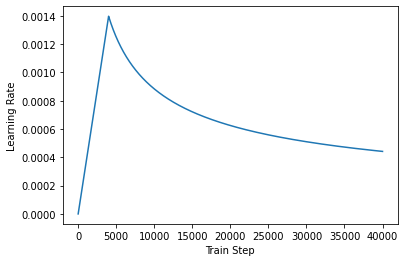

In [47]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.xlabel('Train Step')
plt.ylabel('Learning Rate')

When calculating loss and accuracy, it is important to apply a padding mask since the target sequences are padded.

In [48]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)

  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, dtype=pred.dtype)
  match = label == pred
  mask = label != 0
  match = match & mask
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the training procedure using `model.compile`.

In [49]:
transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

Define a callback for saving checkpoints during training.

In [50]:
checkpoint_dir = 'drive/MyDrive/Transformer/training/training_01'
checkpoint_path = os.path.join(checkpoint_dir, 'cp-{epoch:04d}.ckpt')

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)

If applicable, load the previously saved weights.

In [51]:
if os.path.exists(checkpoint_dir) and len(os.listdir(checkpoint_dir)) > 0:
  latest = tf.train.latest_checkpoint(checkpoint_dir)
  transformer.load_weights(latest)

Train the model with `model.fit`.

In [71]:
epochs = 20

transformer.fit(train_batches, epochs=epochs, validation_data=val_batches, callbacks=[cp_callback])

Epoch 1/20
3252/3252 [==============================] - 949s 289ms/step - loss: 4.4800 - masked_accuracy: 0.2906 - val_loss: 3.5608 - val_masked_accuracy: 0.3836
Epoch 2/20
3252/3252 [==============================] - 934s 287ms/step - loss: 3.3654 - masked_accuracy: 0.3999 - val_loss: 2.9257 - val_masked_accuracy: 0.4608
Epoch 3/20
3252/3252 [==============================] - 934s 287ms/step - loss: 2.9105 - masked_accuracy: 0.4523 - val_loss: 2.6751 - val_masked_accuracy: 0.4931
Epoch 4/20
3252/3252 [==============================] - 939s 289ms/step - loss: 2.6924 - masked_accuracy: 0.4805 - val_loss: 2.5535 - val_masked_accuracy: 0.5108
Epoch 5/20
3252/3252 [==============================] - 934s 287ms/step - loss: 2.5581 - masked_accuracy: 0.4988 - val_loss: 2.4765 - val_masked_accuracy: 0.5234
Epoch 6/20
3252/3252 [==============================] - 933s 287ms/step - loss: 2.4652 - masked_accuracy: 0.5119 - val_loss: 2.4183 - val_masked_accuracy: 0.5297
Epoch 7/20
3252/3252 [======

## Run Inference
The model can now be used to perform translation.

Define the `Translator` class by subclassing `tf.Module`.

In [53]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.ru.tokenize(sentence).to_tensor()
    encoder_input = sentence

    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)
      predictions = predictions[:, -1:, :] # (batch_size, 1, vocab_size)
      predicted_id = tf.argmax(predictions, axis=-1)
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break
    
    output = tf.transpose(output_array.stack())
    text = self.tokenizers.en.detokenize(output)[0]
    tokens = self.tokenizers.en.lookup(output)[0]

    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Create an instance of the `Translator` class and try it out.

In [54]:
translator = Translator(reloaded_tokenizers, transformer)

In [55]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [57]:
sentence = 'это проблема, которую мы должны решить.'
ground_truth = 'this is a problem we have to solve.'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : это проблема, которую мы должны решить.
Prediction     : this is the problem we have to solve .
Ground truth   : this is a problem we have to solve.


## Attention Plots
Create a function that plots the attention when a token is generated.

In [58]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [59]:
head = 0
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([10, 10])

These are the input (Russian) tokens.

In [60]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = reloaded_tokenizers.ru.tokenize(in_tokens).to_tensor()
in_tokens = reloaded_tokenizers.ru.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'\xd1\x8d\xd1\x82\xd0\xbe',
       b'\xd0\xbf\xd1\x80\xd0\xbe\xd0\xb1\xd0\xbb\xd0\xb5\xd0\xbc\xd0\xb0',
       b',', b'\xd0\xba\xd0\xbe\xd1\x82\xd0\xbe\xd1\x80\xd1\x83\xd1\x8e',
       b'\xd0\xbc\xd1\x8b',
       b'\xd0\xb4\xd0\xbe\xd0\xbb\xd0\xb6\xd0\xbd\xd1\x8b',
       b'\xd1\x80\xd0\xb5\xd1\x88\xd0\xb8\xd1\x82\xd1\x8c', b'.',
       b'[END]'], dtype=object)>

These are the output (English) tokens.

In [61]:
translated_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'problem', b'we', b'have',
       b'to', b'solve', b'.', b'[END]'], dtype=object)>

Plot the attention head heatmap.

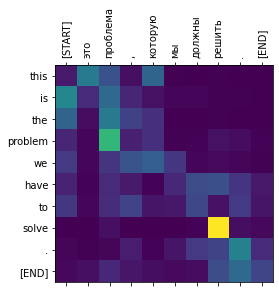

In [62]:
plot_attention_head(in_tokens, translated_tokens, attention)

Add a function for plotting attention weights.

In [65]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = reloaded_tokenizers.ru.tokenize(in_tokens).to_tensor()
  in_tokens = reloaded_tokenizers.ru.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

Plot attention weights for different heads.

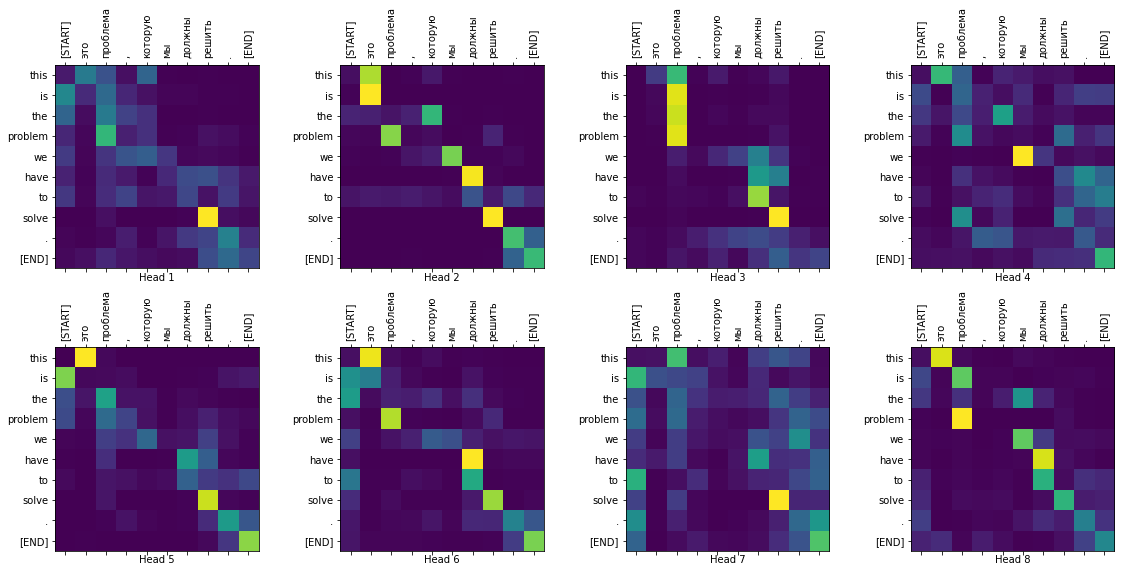

In [66]:
plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Model Export
We can export the trained model as a `tf.saved_model`.

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method.

In [67]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    result, tokens, attention_weights = self.translator(sentence)

    return result

Wrap `translator` in the newly created `ExportTranslator`.

In [68]:
translator = ExportTranslator(translator)

Try out the model.

In [69]:
translator('это проблема, которую мы должны решить.').numpy()

b'this is the problem we have to solve .'

Save the model.

In [71]:
export_path = 'drive/MyDrive/Transformer/translator'

In [72]:
tf.saved_model.save(translator, export_dir=export_path)

Reload the saved model.

In [73]:
reloaded_translator = tf.saved_model.load(export_path)

Use the reloaded model to translate the same sentence. This should yield the same result.

In [74]:
reloaded_translator('это проблема, которую мы должны решить.').numpy()

b'this is the problem we have to solve .'